In [508]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [509]:
# Functions to compute alpha and beta
def get_alpha(u, P):
    if u == 1:
        return np.sqrt(1/P)
    else:
        return np.sqrt(2/P)

def get_beta(v, Q):
    if v == 1:
        return np.sqrt(1/Q)
    else:
        return np.sqrt(2/Q)

In [510]:
# Function to get the basis chip
def get_basis_chip(u, v, P=8, Q=8):
    
    # Compute alpha and beta
    a_u = get_alpha(u, P)
    b_v = get_beta(v, Q)
    
    # Create empty basis chip
    basis_chip = np.zeros((P, Q))
    
    # Calculate the basis chip
    for x in range(1, P+1):
        for y in range(1, Q+1):
            basis_chip[y-1, x-1] = a_u * b_v * np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P)) * np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))
    
    # Return the basis chip with the right orientation
    return basis_chip

In [511]:
# Function to calculate convert basis chip into basis vector
def get_basis_vector_matrix(K=8):
    num_basis_vectors = K**2
    
    # Initialize the 64x64 basis vector matrix
    basis_vector_matrix = np.zeros((num_basis_vectors, num_basis_vectors))
    
    # Get all basis chips and rasterize them into column vectors
    index = 0
    for u in range(1, K + 1):
        for v in range(1, K + 1):
            # Get the basis chip
            basis_chip = get_basis_chip(u, v, P=K, Q=K)
            
            # Rasterize the basis chip into a column vector
            basis_vector_matrix[:, index] = basis_chip.flatten(order='F')
            index += 1

    return basis_vector_matrix

In [512]:
# Generate the 8x8 corrupted image block (chip)
def generate_corrupted(S=30, block_size=8, block=None):
    # Generate the mask
    total_pixels = block_size * block_size
    indices = np.random.choice(total_pixels, S, replace=False)
    
    # Normalize the grayscale block to the range 0–255
    block_normalized = (block - block.min()) / (block.max() - block.min()) * 255
    block_normalized = block_normalized.astype(np.uint8)

    # Generate a mask and set missing pixel intensities to NaN
    mask = np.zeros((block_size, block_size), dtype=bool)
    for index in indices:
        row, col = divmod(index, block_size)
        mask[row, col] = True
    
    # Sets corrupted pixels to NaN
    nan_block = block.astype(float)
    nan_block[~mask] = np.nan
    
    return nan_block, mask
    

In [513]:
def display_top_10_basis_chips(kappa_est):
    # Get indices of the 10 largest magnitude weights
    top_10_indices = np.argsort(np.abs(kappa_est))[-10:]
    top_10_weights = kappa_est[top_10_indices]

    # Determine u and v values
    u_values = top_10_indices // 8 + 1
    v_values = top_10_indices % 8 + 1

    # Plot the 10 basis chips
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))
    fig.suptitle("Top 10 Basis Chips with Highest Weights")

    for i, ax in enumerate(axes.flatten()):
        u, v, weight = u_values[i], v_values[i], top_10_weights[i]
        
        basis_chip = get_basis_chip(u, v, P=8, Q=8)

        ax.imshow(basis_chip, cmap="gray")
        ax.set_title(f"(u, v) = ({u}, {v}), w={weight:.3f}")
        ax.axis("off")

    plt.show()

In [514]:
def apply_lasso_reconstruction(B, block, mask, alpha):
    # Flatten block and mask
    C = block.flatten(order='F')
    sampling_mask = mask.flatten(order='F')

    # Create A and D matrices
    D = C[sampling_mask]
    A = B[sampling_mask, :]

    # Apply LASSO regression
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(A, D)
    kappa_est = lasso.coef_
    intercept = lasso.intercept_

    # Reconstruct image chip
    C_hat = B @ kappa_est + intercept
    C_hat = C_hat.reshape(8, 8, order='F')

    return C_hat, kappa_est


In [515]:
def cross_validation_random(S, mask, corrupted_block, B):
    # Parameters for Cross-validation
    num_testing = S // 6 # Number of pixels in test set
    lambda_values = np.logspace(-7, 2, 11) # Values of λ to test
    
    # Initialize subplots
    fig, axes = plt.subplots(3, len(lambda_values), figsize=(30, 10))
    
    # Initialize list to store MSE values
    mse_values = []
    
    for i, alpha in enumerate(lambda_values):
        # Randomly split sensed pixels into train and test sets
        sensed_pixels = np.argwhere(~np.isnan(corrupted_block))
        np.random.shuffle(sensed_pixels)
        
        test_pixels = sensed_pixels[:num_testing]
        train_pixels = sensed_pixels[num_testing:]

        train_mask = np.zeros_like(corrupted_block, dtype=bool)
        train_mask[tuple(train_pixels.T)] = True
        
        train_block = corrupted_block.copy()
        train_block[~train_mask] = np.nan
        
        # Apply LASSO reconstruction
        reconstructed_block, kappa_est = apply_lasso_reconstruction(B, train_block, train_mask, alpha)
        reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
        
        # Display original corrupted and reconstructed images
        axes[0, i].imshow(corrupted_block, cmap='gray')
        axes[0, i].set_title(f"Corrupted\nλ={alpha:.1e}")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(reconstructed_block, cmap='gray')
        axes[1, i].set_title(f"Reconstructed\nλ={alpha:.1e}")
        axes[1, i].axis("off")
        
        # Stem plot for model weights (kappa_est)
        axes[2, i].stem(kappa_est)
        axes[2, i].set_title(f"Model Weights\nλ={alpha:.1e}")
        axes[2, i].set_xlabel("Coefficient Index")
        axes[2, i].set_ylabel("Weight Value")
        
        # Extract reconstructed values at the test pixel locations
        test_values_reconstructed = reconstructed_block[tuple(test_pixels.T)]
        test_values_original = corrupted_block[tuple(test_pixels.T)]
        
        valid_indices = ~np.isnan(test_values_original) & ~np.isnan(test_values_reconstructed)
        test_values_original = test_values_original[valid_indices]
        test_values_reconstructed = test_values_reconstructed[valid_indices]
        
        # Calculate MSE
        # Compute MSE only if there are valid values
        if len(test_values_original) > 0 and len(test_values_reconstructed) > 0:
                mse = mean_squared_error(test_values_original, test_values_reconstructed)
                mse_values.append(mse)
        else:
                mse_values.append(np.nan)  # Append NaN if no valid values


    plt.suptitle("Comparison of Corrupted vs Reconstructed Image & Model Weights for Different λ")
    plt.tight_layout()
    plt.show()
    
    # Plot MSE vs lambda
    plt.figure(figsize=(8, 6))
    plt.plot(lambda_values, mse_values, marker='o', linestyle='-')
    plt.xscale('log')  # Log scale for lambda
    plt.xlabel(r'Regularization Parameter $\lambda$')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs. Regularization Parameter $\lambda$')
    plt.grid(True)
    plt.show()


In [516]:
def display_model_weight(kappa_est):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.stem(range(len(kappa_est)), kappa_est, use_line_collection=True)
    ax.set_xlabel("Basis Vector Index")
    ax.set_ylabel("Weight Magnitude")
    ax.set_title("Model Weights for Selected λ")
    plt.show()

In [517]:
# Function display the original block vs the reconstructed block
def display_reconstructed(original_block, reconstructed_block):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(original_block, cmap='gray')
    ax[0].set_title("Original Block")
    ax[1].imshow(reconstructed_block, cmap='gray')
    ax[1].set_title("Reconstructed Block")
    plt.show()

In [518]:
# Function to calculate the MSE between the original and reconstructed block
def calculate_mse(original_block, reconstructed_block):
    mse = mean_squared_error(original_block.flatten(order='F'), reconstructed_block.flatten(order='F'))
    print(f"Mean Squared Error (MSE) between original and reconstructed image chip: {mse:.4f}")

In [519]:
# Load image
image_path = '../data/fishing_boat.bmp'
image = Image.open(image_path).convert('L')

# Convert the image to a numpy array
image_array = np.array(image)

In [520]:
# Display the 8x8 block with the top-left pixel at (x, y) = (x*, y*)
x_star = 8 * (4-1) + 1
y_star = 8 * (2-1) + 1

# Get the 8x8 block
block_size = 8
x_start = x_star - 1
y_start = y_star - 1

# Get the block end coordinates
x_end = min(x_start + block_size, image_array.shape[0])
y_end = min(y_start + block_size, image_array.shape[1])

# Gets the 8x8 block
block = image_array[x_start:x_end, y_start:y_end]

In [521]:
# Generate the 8x8 corrupted image block (chip)
S = 30
corrupted_block, mask = generate_corrupted(S, block_size=8, block=block)

In [522]:
# Get the vector matrix
B = get_basis_vector_matrix(K=8)

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.818e-01, tolerance: 2.258e-01
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_410562/420598791.py:28: RuntimeWarning: invalid value encountered in divide
  reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
/tmp/ipykernel_410562/420598791.py:28: RuntimeWarning: invalid value encountered in divide
  reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (reconstructed_block.max() - reconstructed_block.min()) * 255
/tmp/ipykernel_410562/420598791.py:28: RuntimeWarning: invalid value encountered in divide
  reconstructed_block = (reconstructed_block - reconstructed_block.min()) / (rec

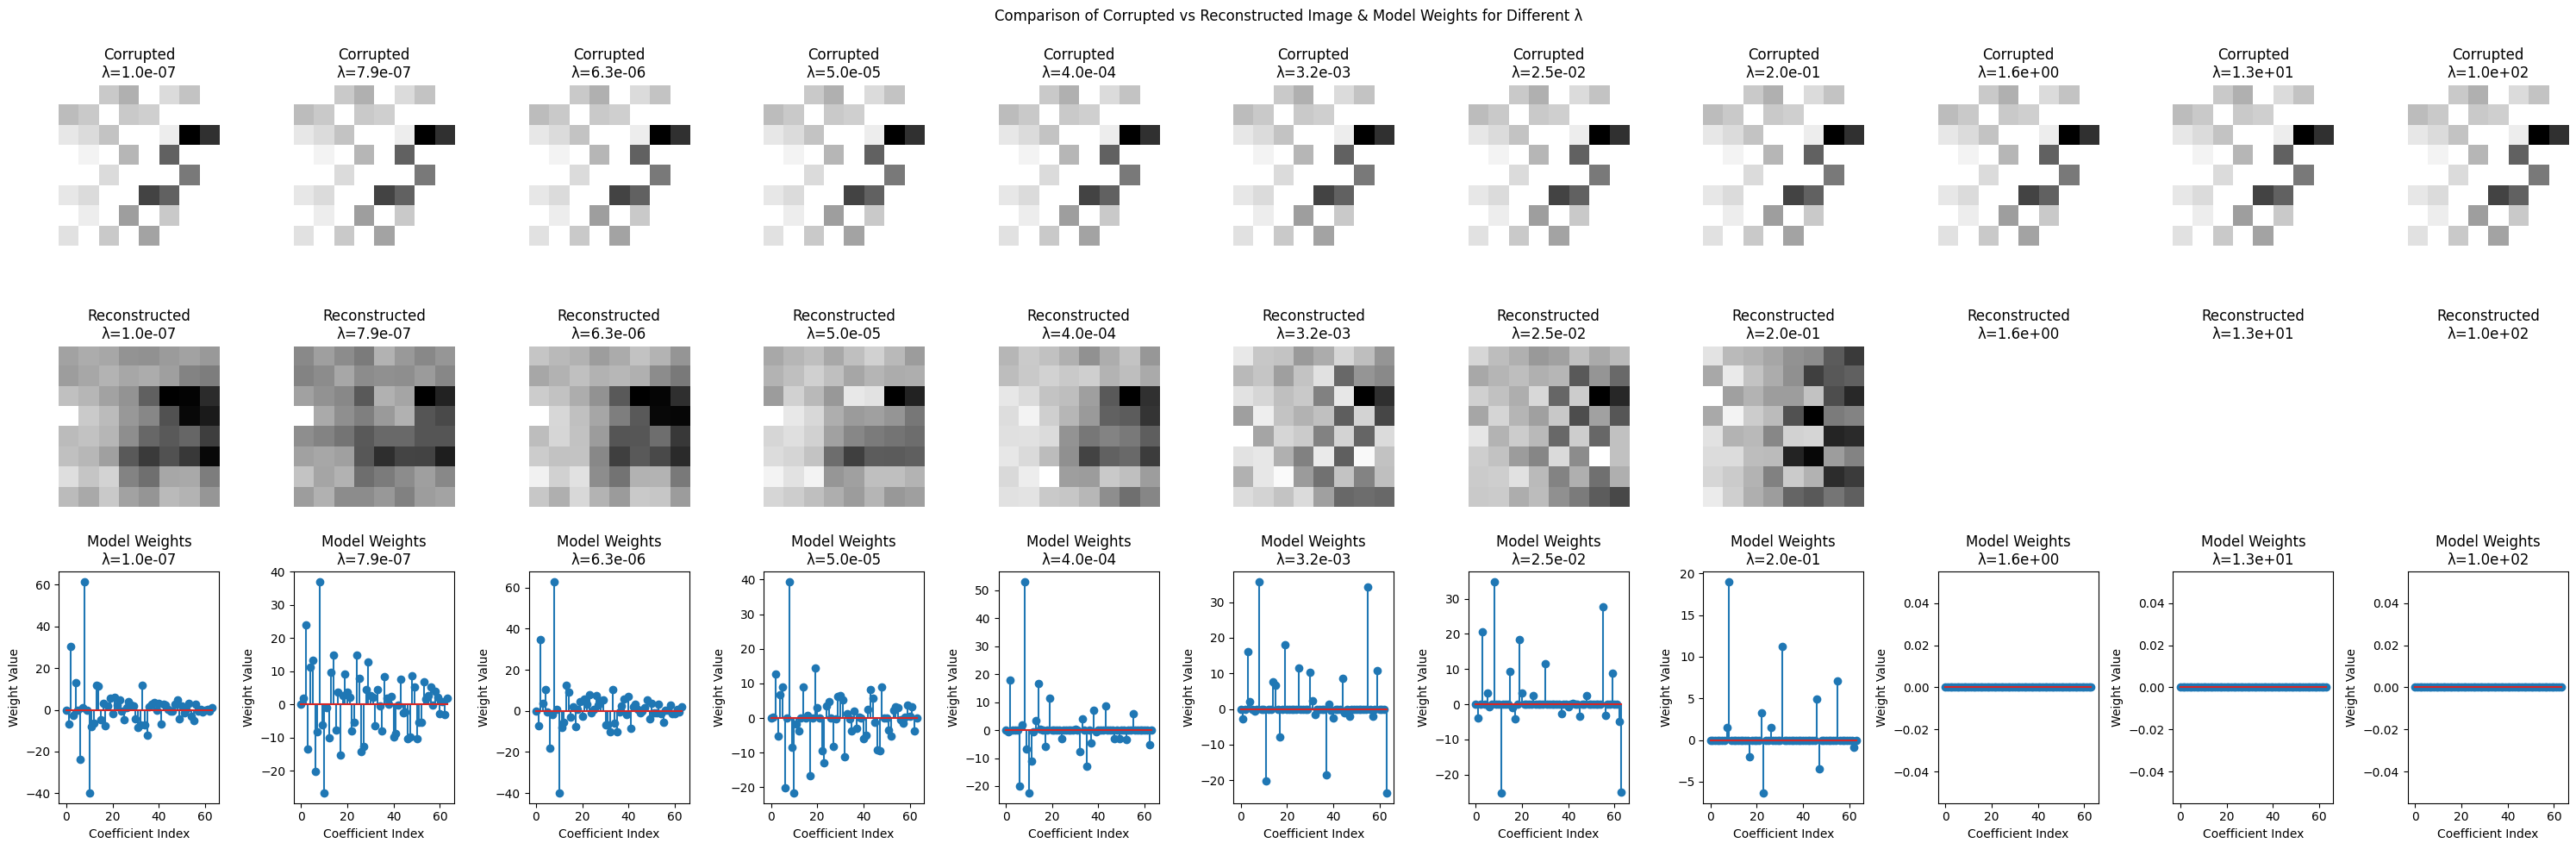

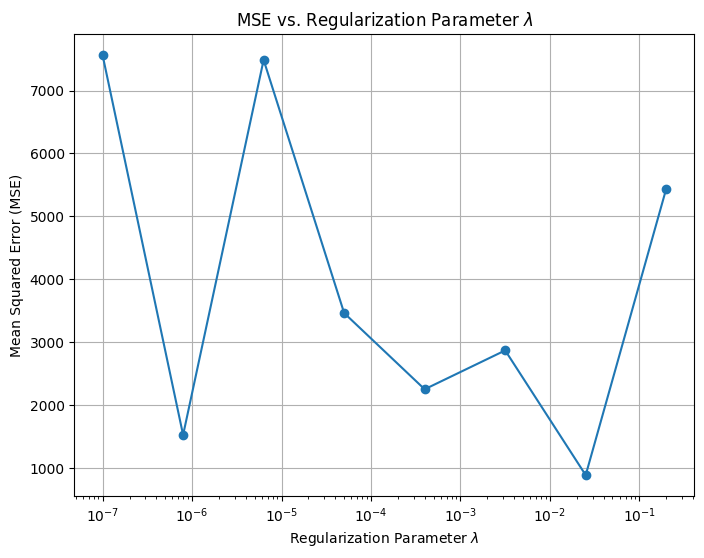

In [523]:
# Chip reconstruction
cross_validation_random(S, 30, corrupted_block, B)